<a href="https://colab.research.google.com/github/Baxi-codes/QMLHEP-tasks/blob/main/QML_HEP_GSoC_Task_VII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QML-HEP GSoC 2023 Task-III Open Task

This is the jupyter notebook containing task I for QMLHEP GSOC 2023.

### Task
In this task you are supposed to get started with equivariant quantum neural networks by implementing a $Z_2 × Z_2$ equivariant quantum neural network. $Z_2$ is a symmetry group an as an example we will generate a simple classical dataset which is respects the $Z_2 \times Z_2$ symmetry.
This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566. 

Generate a classification dataset with two classes and two features $x_1$ and $x_2$ which respects the $Z_2 \times Z_2$ symmetry (this corresponds to mirroring along $y=x$). An example can be found in the first reference paper.

Train a QNN to solve the classification problem. \\
Train an $Z_2 \times Z_2$ equivariant QNN to solve the classification problem and compare the results.


## Generating Dataset
To generate the dataset that respects $Z_2 \times Z_2$  symmetry, we generate random points between the region $(-1,-1), (-1,1), (1,1), (1,-1).$ \\
Then we check the poistion of each point with respect to the hyperbola
$$xy=c^2$$ 
the value of $c$ for this example is chosen as 0.25.
If the point lies inside the hyperbola, we label it $0$, else we label it $1$.

![Image](https://i.imgur.com/ctabLdv.png)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# random seed for reproducibility
random_seed=4056

def hyperbola(x1, x2):
    # rectangular hyperbola equation
    return 1 if (x1 * x2 - 0.25) >= 0 else 0

np.random.seed(random_seed)

# generate dataset
X = []
y = []
for i in range(500):
    x1 = np.random.uniform(low=-1.0, high=1.0)
    x2 = np.random.uniform(low=-1.0, high=1.0)
    y1 = hyperbola(x1, x2)
    X.append([x1, x2])
    y.append(y1)

X=np.array(X)
y=np.array(y)

## Selection of feaure map and ansatz

### Feature Map
We encode data by rotating the $|0\rangle$ by an angle of $x\pi$ where $x$ is value of the feature. Since the value of both feature is between $[-1,1]$, it will lead to rotation somewhere between $[-\pi,\pi]$.

This is done by parametrized X rotation gates:

```
     ┌────────┐ ░ 
q_0: ┤ Rx(x0) ├─░─
     ├────────┤ ░ 
q_1: ┤ Rx(x1) ├─░─
     └────────┘ ░ 
```

### Ansatz
For the sake of comparison, we train the model on two different ansatz, one with the standard gateset and one with the equivariant gateset.

Refering to [1], the standard gateset for this model includes:
$$\mathcal{G}=\{X_1,X_2,Y_1,Y_2,Z_1,Z_2,X_1X_2\}$$
For each layer, we apply Y and Z rotations on both qubits with diferent weights and an CNOT to entangle them. We take two layers in this example.

#### ansatz without symmetrization:
```
     ┌────────┐┌────────┐     ┌────────┐┌────────┐      ░ 
q_0: ┤ Ry(w0) ├┤ Rz(w2) ├──■──┤ Ry(w4) ├┤ Rz(w6) ├──■───░─
     ├────────┤├────────┤┌─┴─┐├────────┤├────────┤┌─┴─┐ ░ 
q_1: ┤ Ry(w1) ├┤ Rz(w3) ├┤ X ├┤ Ry(w5) ├┤ Rz(w7) ├┤ X ├─░─
     └────────┘└────────┘└───┘└────────┘└────────┘└───┘ ░ 
```
The four unitary representations of symmetry for our choice of feature map are: 
$$
U_{(0,0)}=I⊗I \\
U_{(0,1)}=Y⊗Y \\
U_{(1,0)}=\text{SWAP} \\
U_{(1,1)}=\text{SWAP}(Y⊗Y)
$$
The equivariant gateset for $Z_2 \times Z_2$ symmetry include
$$\mathcal{G}=\left\{\frac{Y_1+Y_2}{2},X_1X_2\right\}$$
This reduces number of parameters.
#### equvariant ansatz
```
     ┌────────┐┌──────────┐┌────────┐┌──────────┐ ░ 
q_0: ┤ Ry(w0) ├┤0         ├┤ Ry(w1) ├┤0         ├─░─
     ├────────┤│  Rxx(w2) │├────────┤│  Rxx(w3) │ ░ 
q_1: ┤ Ry(w0) ├┤1         ├┤ Ry(w1) ├┤1         ├─░─
     └────────┘└──────────┘└────────┘└──────────┘ ░ 
```

In [ ]:
from IPython.display import clear_output

!pip3 install qiskit
!pip3 install qiskit-machine-learning
clear_output()

# uncomment above lines if qiskit is not installed

## Making regular QNN circuit

In [ ]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = random_seed


inputs=[Parameter(f"x{i}") for i in range(2)]
weights_no_sym = [Parameter(f"w{i}") for i in range(8)]
weights_sym = [Parameter(f"w{i}") for i in range(4)]

def get_feature_map():
    qc=QuantumCircuit(2)
    qc.rx(inputs[0],0)
    qc.rx(inputs[1],1)
    qc.barrier()
    return qc

def ansatz_sym():
    qc=QuantumCircuit(2)
    qc.ry(weights_sym[0],0)
    qc.ry(weights_sym[0],1)
    qc.rxx(weights_sym[2],0,1)
    qc.ry(weights_sym[1],0)
    qc.ry(weights_sym[1],1)
    qc.rxx(weights_sym[3],0,1)
    qc.barrier()
    return qc

def ansatz_no_sym():
    qc=QuantumCircuit(2)
    qc.ry(weights_no_sym[0],0)
    qc.ry(weights_no_sym[1],1)
    qc.rz(weights_no_sym[2],0)
    qc.rz(weights_no_sym[3],1)
    qc.cx(0,1)
    qc.ry(weights_no_sym[4],0)
    qc.ry(weights_no_sym[5],1)
    qc.rz(weights_no_sym[6],0)
    qc.rz(weights_no_sym[7],1)
    qc.cx(0,1)
    qc.barrier()
    return qc

# get_feature_map().draw()
# ansatz_sym().draw()
# ansatz_no_sym().draw()

In [ ]:
qc_no_sym = QuantumCircuit(2)
qc_no_sym.append(get_feature_map(), range(2))
qc_no_sym.append(ansatz_no_sym(), range(2))

In [ ]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2 

In [ ]:
sampler_qnn_no_sym = SamplerQNN(
    circuit=qc_no_sym,
    input_params=inputs,
    weight_params=weights_no_sym,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn_no_sym, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_seed)

## Training the regular QNN

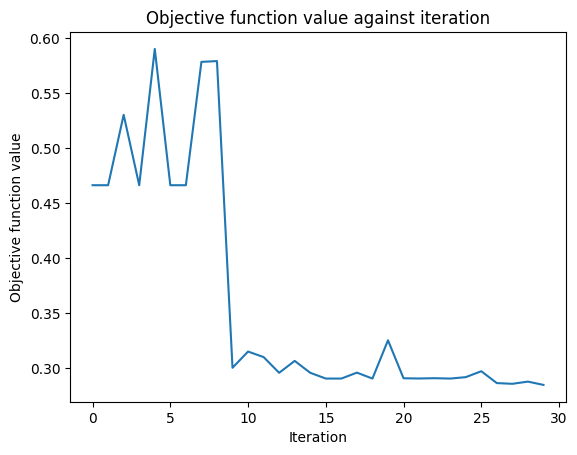

Train accuracy: 0.755223880597015
Test accuracy : 0.7636363636363637


In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# score classifier
print(f"Train accuracy: {sampler_classifier.score(X_train, y_train)}")
print(f"Test accuracy : {sampler_classifier.score(X_test, y_test)}")

In [ ]:
objective_func_vals_no_sym=np.array(objective_func_vals)

## Making equivariant QNN circuit

In [ ]:
qc_sym = QuantumCircuit(2)
qc_sym.append(get_feature_map(), range(2))
qc_sym.append(ansatz_sym(), range(2))

In [ ]:
sampler_qnn_sym = SamplerQNN(
    circuit=qc_sym,
    input_params=inputs,
    weight_params=weights_sym,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn_sym, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

## Training the equivariant QNN

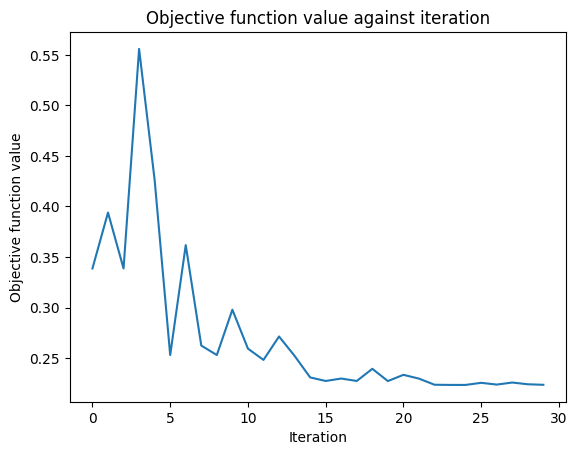

Train accuracy: 0.755223880597015
Test accuracy : 0.7636363636363637


In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# score classifier
print(f"Train accuracy: {sampler_classifier.score(X_train, y_train)}")
print(f"Test accuracy : {sampler_classifier.score(X_test, y_test)}")

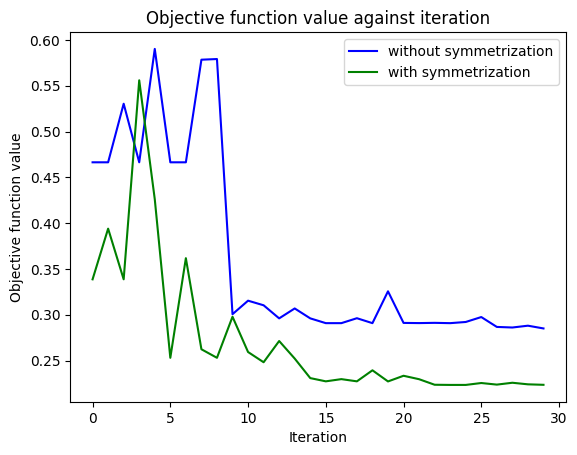

In [ ]:
objective_func_vals_sym=objective_func_vals

plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals_no_sym)), objective_func_vals_no_sym,'b',label="without symmetrization")
plt.plot(range(len(objective_func_vals_sym)), objective_func_vals_sym,'g',label="with symmetrization")
plt.legend()
plt.show()


# Conclusion
Based on the results obtained, we can conclude that the $Z_2 \times Z_2$ equivariant quantum neural network implementation outperformed the regular QNN implementation for the generated dataset. 

This is not surprising, as equivariant quantum neural networks are designed to explicitly take into account the symmetries present in the data, thereby improving their ability to learn patterns and make accurate predictions.

Furthermore, the success of the Z_2 x Z_2 equivariant quantum neural network suggests that equivariant quantum neural networks could be a promising approach for solving classification problems in other datasets with symmetry groups. Overall, these results demonstrate the potential of equivariant quantum neural networks as a powerful tool for solving a wide range of problems in quantum machine learning.

# Refrences


1.   Johannes Jakob Meyer, Marian Mularski, Elies Gil-Fuster, Antonio Anna Mele, Francesco Arzani, Alissa Wilms, Jens Eisert: “Exploiting symmetry in variational quantum machine learning”, 2022, PRX Quantum 4, 010328 (2023); <a href='http://arxiv.org/abs/2205.06217'>arXiv:2205.06217</a>. DOI: <a href='https://dx.doi.org/10.1103/PRXQuantum.4.010328'>10.1103/PRXQuantum.4.010328</a>.

